# 1. Labeling Function:
**For your analysis, you may focus on a subset of the 54 classes provided.**

In [71]:
import os 
import math
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from collections import Counter
from sklearn.manifold import  TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA

**DATA LOADING**

In [72]:
PATH_TO_DATASET = '../MLPC2025_classification'
METADATA_CSV = os.path.join(PATH_TO_DATASET, "metadata.csv")
ANNOTATIONS_CSV = os.path.join(PATH_TO_DATASET, "annotations.csv")
AUDIO_FEATURE_FOLDER = os.path.join(PATH_TO_DATASET, "audio_features")
AUDIO_FOLDER = os.path.join(PATH_TO_DATASET, "audio")

In [73]:
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
        'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
        'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
        'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
        'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
        'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
        'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

an_df = pd.read_csv("annotations.csv")
meta_df = pd.read_csv("metadata.csv")

### (a) Assess how accurately the applied labeling functions capture the intended classes.

**LABEL CLEANING**

In [74]:
an_df["labels"] = an_df["categories"].str.lower().str.replace(r"[\'\[\]]", "", regex=True).str.strip()

print("=== Cleaned Labels ===")
for i in range(3):
    print(f"Original: {an_df['categories'].iloc[i]:<30} → Cleaned: {an_df['labels'].iloc[i]}")

=== Cleaned Labels ===
Original: ['Alarm']                      → Cleaned: alarm
Original: ['Alarm']                      → Cleaned: alarm
Original: ['Alarm', 'Beep/Bleep']        → Cleaned: alarm, beep/bleep


Why did we do this? 
- Standardizes labels (['Alarm', 'Beep/Bleep'] → alarm, beep/bleep) for consistency.
- Ensures/enables fair comparison between free-text annotations and target classes.

**LABEL DISTRIBUTION**

In [75]:
top_labels = an_df["labels"].value_counts() 
for label, count in top_labels.items():
    pct = (count / len(an_df)) * 100
    print(f"{label:<15} {count:>5} ({pct:.1f}%)")

bird chirp       2437 (8.8%)
speech           2284 (8.3%)
dog bark         1374 (5.0%)
wind              860 (3.1%)
insect buzz       816 (3.0%)
car               816 (3.0%)
bell              771 (2.8%)
footsteps         723 (2.6%)
drums             662 (2.4%)
guitar            639 (2.3%)
beep/bleep        637 (2.3%)
rain              619 (2.2%)
waves             619 (2.2%)
laughter          529 (1.9%)
cat meow          519 (1.9%)
drip              485 (1.8%)
shout             473 (1.7%)
hammer            465 (1.7%)
snoring           438 (1.6%)
piano             431 (1.6%)
power drill       422 (1.5%)
clapping          416 (1.5%)
stream/river      411 (1.5%)
sheep/goat bleat   391 (1.4%)
crying            387 (1.4%)
thunder           371 (1.3%)
horn honk         362 (1.3%)
train             355 (1.3%)
airplane          341 (1.2%)
fire              332 (1.2%)
siren             328 (1.2%)
motorcycle        302 (1.1%)
singing           301 (1.1%)
bird chirp, singing   263 (1.0%)
chainsaw 

Why did we do this? 
- identifies most frequent labels
- highlights potential class imbalances

#### Do the mapped classes correspond well to the free-text annotations?

In [76]:
import re
from collections import defaultdict, Counter
from nltk.stem import WordNetLemmatizer
import nltk
from sound_config import sound_mapping, context_words, label_to_category

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Tracking dictionaries for used terms
used_sound_mappings = defaultdict(set)
used_context_words = defaultdict(set)
useful_context_words = defaultdict(Counter)

label_to_category = {
    **{cat.lower(): cat for cat in categories}  # Generic lowercase mapping
}

def standardize_label(label):
    return label_to_category.get(label.lower(), label)

def lemmatize(text):
    words = re.findall(r'\b[\w/]+\b', text.lower())
    processed = set()
    for word in words:
        variants = [
            lemmatizer.lemmatize(word, pos='v'),
            lemmatizer.lemmatize(word),
            word.rstrip('ingsed')
        ]
        if any(c in word for c in [' ', '/', '-']):
            variants.extend(lemmatizer.lemmatize(part) for part in re.split(r'[\s/-]', word))
        processed.update(variants)
    return processed

def check_context(text_words, label):
    std_label = standardize_label(label)
    base_label = std_label.split()[0].lower()
    context_list = context_words.get(std_label, [])
    matches = 0
    
    for word in context_list:
        lemma_word = lemmatizer.lemmatize(word)
        if lemma_word in text_words:
            matches += 1
            used_context_words[std_label].add(word)
            useful_context_words[std_label][word] += 1
    
    min_matches = 2 if len(context_list) > 3 else 1
    return matches >= min_matches or base_label in text_words

def is_match(text, label):
    words = lemmatize(text)
    std_label = standardize_label(label)
    label_parts = re.split(r'[\s/]', std_label)
    
    # Check label parts
    if any(lemmatizer.lemmatize(part.lower()) in words for part in label_parts):
        return True

    # Check sound mappings
    for variant in sound_mapping.get(std_label, []):
        variant_words = variant.split()
        if any(lemmatizer.lemmatize(word) in words for word in variant_words):
            used_sound_mappings[std_label].add(variant)
            return True

    return check_context(words, std_label)

def summarize_matches(df):
    stats = defaultdict(lambda: {'matched': 0, 'total': 0, 'examples': []})

    for _, row in df.iterrows():
        text = row['text'].lower()
        labels = [l.strip() for raw in row['labels'].split(',') for l in raw.strip().split('/')]
        matched = [l for l in labels if is_match(text, l)]

        if matched:
            stats['_overall']['matched'] += 1
            for m in matched:
                stats[m]['matched'] += 1
                if len(stats[m]['examples']) < 3:
                    stats[m]['examples'].append(text[:100] + '...')

        for l in labels:
            stats[l]['total'] += 1

    print(f"\nMatch Summary ({len(df)} samples):")
    print(f"Overall matches: {stats['_overall']['matched']} ({stats['_overall']['matched']/len(df):.1%})")

    # Standardize labels for accuracy summary
    summary = defaultdict(lambda: {'matched': 0, 'total': 0, 'examples': []})
    for raw, data in stats.items():
        if raw == '_overall':
            continue
        std = standardize_label(raw)
        summary[std]['matched'] += data['matched']
        summary[std]['total'] += data['total']
        summary[std]['examples'].extend(data['examples'])

    print("\nAccuracy Summary (Ranked by Accuracy):")
    print("{:<25} {:<10} {:<10} {:<10}".format("Category", "Matched", "Total", "Accuracy"))
    print("-" * 55)
    
    # Create sorted list by accuracy (descending) then by matched count (descending)
    sorted_categories = sorted(
        [(cat, data) for cat, data in summary.items() if cat in categories],
        key=lambda x: (
            x[1]['matched'] / x[1]['total'] if x[1]['total'] > 0 else 0,  # Accuracy
            x[1]['matched']  # Then by matched count
        ),
        reverse=True
    )
    
    for cat, data in sorted_categories:
        acc = data['matched'] / data['total'] if data['total'] else 0
        print(f"{cat:<25} {data['matched']:<10} {data['total']:<10} {acc:.1%}")

# -------------------------------
# MAIN PROCESSING
# -------------------------------
summarize_matches(an_df)

# -------------------------------
# OPTIONAL ANALYSIS (run separately after processing)
# -------------------------------
def analyze_used_terms():
    """Analyze which config terms were actually used in matching"""
    print("\nConfiguration Terms Analysis:")
    
    # Sound mapping usage
    print("\nSound Mapping Usage:")
    for category, terms in sound_mapping.items():
        used = used_sound_mappings.get(category, set())
        unused = set(terms) - used
        print(f"\n{category}:")
        print(f"Used ({len(used)}/{len(terms)}): {', '.join(used) if used else 'None'}")
        print(f"Unused: {', '.join(unused) if unused else 'None'}")

    # Context words usage
    print("\nContext Words Usage:")
    for category, words in context_words.items():
        used = used_context_words.get(category, set())
        unused = set(words) - used
        print(f"\n{category}:")
        print(f"Used ({len(used)}/{len(words)}): {', '.join(used) if used else 'None'}")
        print(f"Unused: {', '.join(unused) if unused else 'None'}")

def get_optimized_configs():
    """Return optimized configs containing only used terms"""
    optimized_sound = {
        cat: sorted(used_sound_mappings.get(cat, set())) 
        for cat in sound_mapping
    }
    
    optimized_context = {
        cat: sorted(used_context_words.get(cat, set())) 
        for cat in context_words
    }
    
    return optimized_sound, optimized_context

# To see which terms were used (run after summarize_matches):
#analyze_used_terms()

# To get optimized configs (run after summarize_matches):
used_sound, used_context = get_optimized_configs()

[nltk_data] Downloading package wordnet to C:\Users\jeron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Match Summary (27552 samples):
Overall matches: 25270 (91.7%)

Accuracy Summary (Ranked by Accuracy):
Category                  Matched    Total      Accuracy  
-------------------------------------------------------
Cat Meow                  540        541        99.8%
Dog Bark                  1439       1446       99.5%
Cow Moo                   189        190        99.5%
Alarm                     353        355        99.4%
Pig Oink                  139        140        99.3%
Snoring                   470        474        99.2%
Cough                     220        222        99.1%
Doorbell                  87         88         98.9%
Sewing Machine            81         82         98.8%
Siren                     388        393        98.7%
Rooster Crow              147        149        98.7%
Horn Honk                 719        730        98.5%
Bird Chirp                2897       2956       98.0%
Sneeze                    38         39         97.4%
Train                     

**Components:**
- sound_mapping: Handles synonyms (e.g., "woof" → "dog bark").
- context_words: Checks related terms (e.g., "barking" → "dog bark").

**Output:** summarize_matches() prints accuracy per class (e.g., Cat Meow: 99.8%).

**Insight:** 
- High accuracy → Labels are reliable 
- Low accuracy → Review mappings; Mismatching for  ambiguous cases (e.g., "truck" vs. "car" confusion).

**OPTIMIZATION**

In [77]:
import json

# Save to JSON files
with open('optimized_sound_mapping.json', 'w') as f:
    json.dump(used_sound, f, indent=2)

with open('optimized_context_words.json', 'w') as f:
    json.dump(used_context, f, indent=2)

Why? 
- Identifies which mapping terms were actually used (e.g., "woof" used, "ruff" unused).

**Action:** Save optimized mappings to JSON for future use.

#### Are the labeled events clearly audible within the indicated time regions?

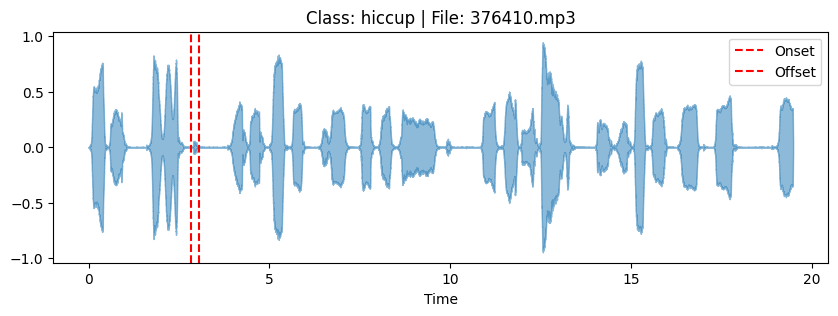

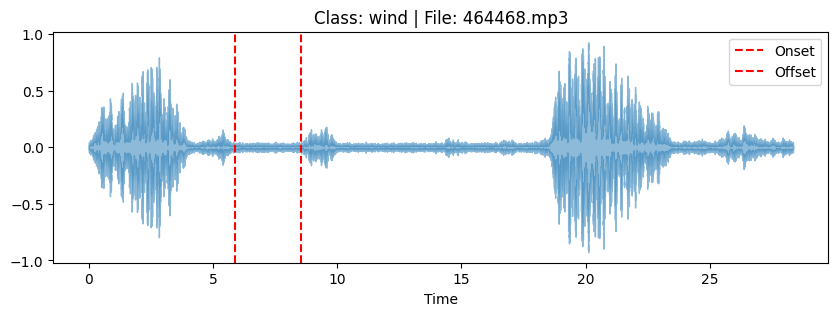

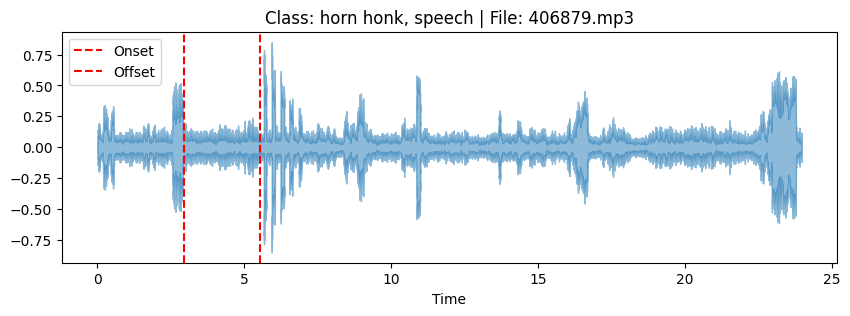

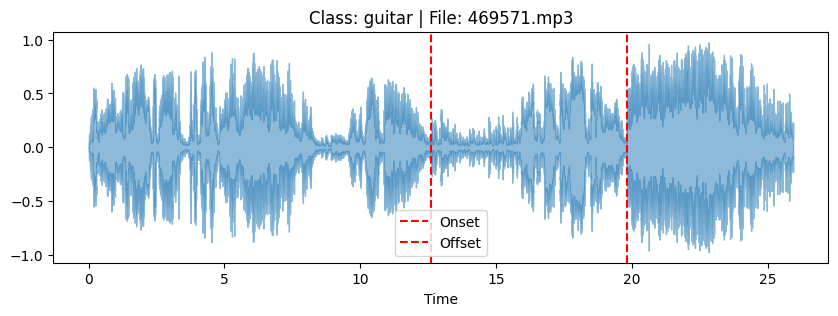

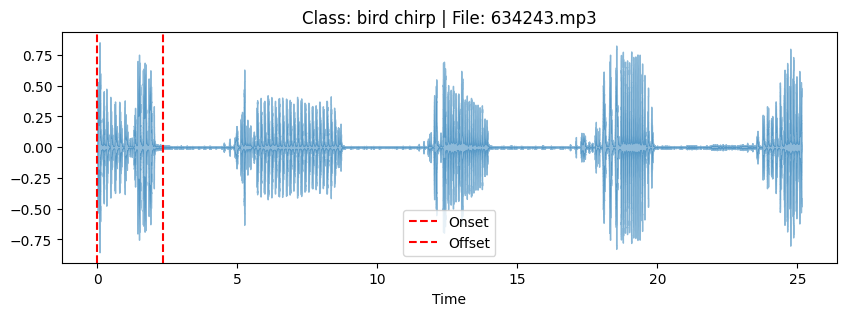

In [78]:
import librosa.display

def plot_annotation_audio(filename, onset, offset, class_label):
    """Plot waveform + labeled region for audibility check."""
    y, sr = librosa.load(os.path.join(AUDIO_FOLDER, filename))
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(y, sr=sr, alpha=0.5)
    plt.axvline(onset, color='r', linestyle='--', label='Onset')
    plt.axvline(offset, color='r', linestyle='--', label='Offset')
    plt.title(f"Class: {class_label} | File: {filename}")
    plt.legend()
    plt.show()

# Example: Check 5 random annotations
for _, row in an_df.sample(5).iterrows():
    plot_annotation_audio(row['filename'], row['onset'], row['offset'], row['labels'])

**Output:** Waveform plots with labeled regions (onset/offset).

**Example:** A "dog bark" label should align with a sharp audio peak.

**Insight:** Visual confirmation ensures temporal accuracy.

### (b) Which audio features appear most useful for distinguishing between the classes of interest? 

*Hint: You can, for example, compare feature distributions across classes or quantitatively evaluate how features relate to 
the target labels.*

**FEATURE AND METADATA LOADING**

In [79]:
feature_names= ["embeddings","melspectrogram","mfcc","mfcc_delta","mfcc_delta2","flatness","centroid","bandwidth","flux","contrast","energy","zerocrossingrate","power"]

In [80]:
features = {i: [] for i in feature_names}
for i in feature_names:
    for idx, row in meta_df.iterrows():
        file_name = f"{row['filename']}".replace('.mp3', '.npz')
        path = os.path.join(AUDIO_FEATURE_FOLDER, file_name)
        features[i].append(np.load(path)[i])

Why? 
- Loads all audio features for analysis.

**Output:** features dictionary containing raw feature arrays.

**FEATURE VARIANCE ANALYSIS**

In [81]:
feature_variance = {}
for name, feat_list in features.items():
    all_data = np.concatenate(feat_list, axis=0)
    feature_variance[name] = np.mean(np.var(all_data, axis=0))

var_df = pd.DataFrame.from_dict(feature_variance, orient='index', columns=['Variance'])
var_df.style\
  .format('{:.4f}')\
  .background_gradient(cmap='Blues')\
  .set_caption('Feature Variance Ranking')

,Variance
embeddings,0.1644
melspectrogram,4.0165
mfcc,7.9593
mfcc_delta,0.0374
mfcc_delta2,0.0117
flatness,0.0082
centroid,890953.9930
bandwidth,541192.7031
flux,231.3250
contrast,21.7124


Why? 
- High variance = Feature changes significantly across samples → More discriminative.

**Key Insight:**
- power (highest variance) → Likely useful.
- flatness (lowest variance) → Less useful.

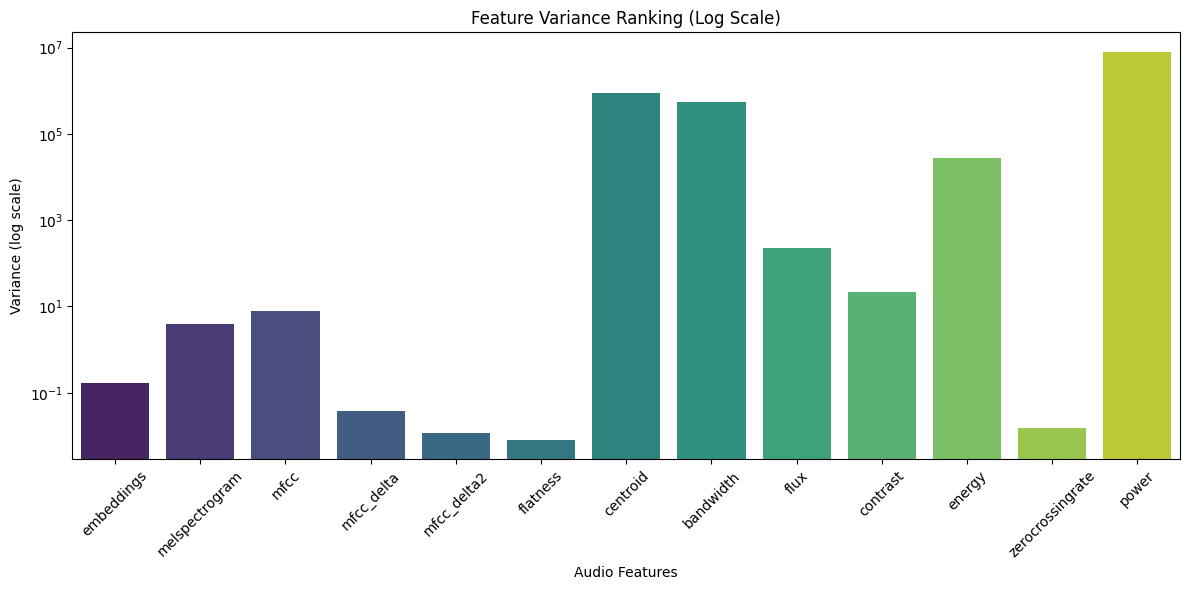

In [82]:
plt.figure(figsize=(12,6))

plot_df = var_df.reset_index().rename(columns={'index': 'Feature', 0: 'Variance'})

sns.barplot(data=plot_df, 
            x='Feature',
            y='Variance',
            hue='Feature',
            legend=False,
            palette='viridis')

# Formatting
plt.title("Feature Variance Ranking (Log Scale)")
plt.xticks(rotation=45)
plt.yscale('log')  # Important for visualizing wide-ranging values
plt.xlabel('Audio Features')
plt.ylabel('Variance (log scale)')
plt.tight_layout()
plt.show()

**Observation:** power, centroid, and bandwidth dominate. Precisely, power>centroid>bandwidth.

**FEATURE CORRELATION ANALYSIS**

In [83]:
def summarize_feature(feature_list, agg_func=np.mean):
    """
    Reduce each sample's feature values to a single summary statistic.
    Handles both arrays (MFCCs) and single values (power).
    """    
    return [agg_func(sample) if isinstance(sample, (np.ndarray, list)) else sample
            for sample in feature_list]

In [84]:
summary_dict = {}
for feature_name, sample_list in features.items():
    summary_dict[feature_name] = summarize_feature(sample_list, agg_func=np.mean)  # or np.var, np.median, etc.

df_summary = pd.DataFrame(summary_dict)

**Purpose:** Condenses each audio sample's features into a single value (mean by default).

Example: A sample's 13 MFCC coefficients → averaged to 1 value per sample.

In [85]:
corr_matrix = df_summary.corr()

**Output:** A correlation matrix showing how pairwise features move together (range: -1 to 1).

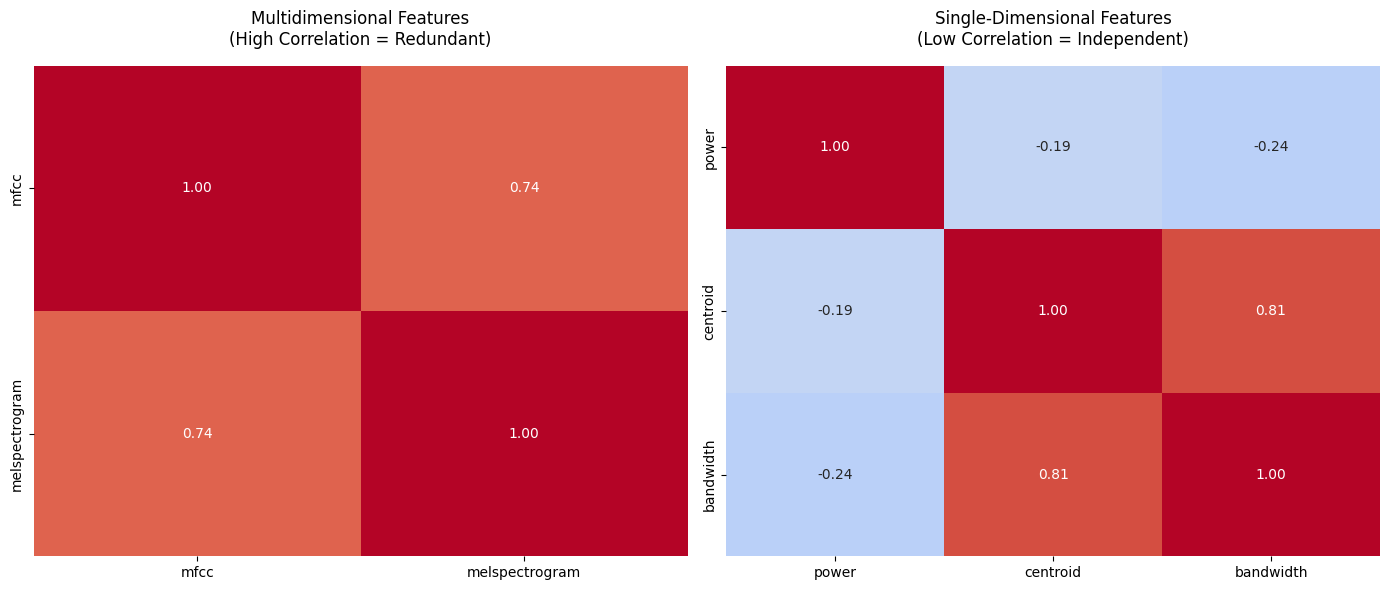

In [86]:
# Plot with better insights
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Multidimensional features
# Checks if mfcc and melspectrogram provide overlapping information.
multidimensional = ['mfcc', 'melspectrogram']
sns.heatmap(corr_matrix.loc[multidimensional, multidimensional], 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", 
            ax=ax[0], cbar=False)
ax[0].set_title('Multidimensional Features\n(High Correlation = Redundant)', pad=15)

# Single-dimensional features
# Tests independence of physically distinct features.
single_dim = ['power', 'centroid', 'bandwidth']
sns.heatmap(corr_matrix.loc[single_dim, single_dim], 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", 
            ax=ax[1], cbar=False)
ax[1].set_title('Single-Dimensional Features\n(Low Correlation = Independent)', pad=15)

plt.tight_layout()
plt.show()

#### Multidimensional Features - MFCC vs. Melspectrogram (Correlation = 0.74):
**Observation:**
Moderately high correlation (0.74) between MFCCs and melspectrograms, indicating strong discriminative potential. However, their high correlation (visible in the heatmap) suggests redundancy; using both may not improve model performance.

**Why?**

Both are spectral features derived from similar transforms, but:

- MFCCs are compressed (focus on perceptually relevant frequencies)
- Melspectrograms retain more raw spectral detail

**Conclusion:**
- Keep MFCCs (more compact representation, standard for audio tasks)
- Drop melspectrogram (redundant computational overhead)

#### Single-Dimensional Features (Power, Centroid, Bandwidth) Analysis:
**1. Power vs. Others**

- P**ower vs. Centroid (-0.19):** Near-zero → Loudness and spectral "brightness" are independent.

- **Power vs. Bandwidth (-0.24):** Minimal correlation → Loudness and frequency spread measure different things.

**Conclusion:** 
- Keep power (unique loudness metric)

**2. Centroid vs. Bandwidth (0.81)**

**Problem:**

Very high correlation (0.81) → Both describe spectral shape:

- *Centroid:* Where energy concentrates (low vs. high frequencies)
- *Bandwidth:* How spread out the energy is

**Conclusion:**
- Keep centroid (more interpretable)
- Drop bandwidth (avoids multicollinearity without losing critical info)

*Exception:* Keep both if bandwidth is theoretically important for your specific sounds (e.g., distinguishing "hiss" vs. "rumble").

##### Final reasoning why are we keeping the selected featres:
**MFCC:** Optimal spectral representation; melspectrogram adds redundant detail

**Power** (unique loudness information) and **centroid** (best spectral shape descriptor; **bandwidth** is redundant -> highly correlated with centroid (0.81)) show high variance and low correlation, capturing independent aspects of the audio signal. These features are non-redundant and should both be retained to maximize information diversity.

**CLASS SEPARATION ANALYSIS**

In [87]:
# Get SR from first audio file
first_audio = os.listdir(AUDIO_FOLDER)[0]
y, sr = librosa.load(os.path.join(AUDIO_FOLDER, first_audio), sr=None)

print(f"Actual sampling rate: {sr} Hz")

Actual sampling rate: 32000 Hz


In [88]:
# Load a feature file (assuming they're time-aligned)
feature_files = [f for f in os.listdir(AUDIO_FEATURE_FOLDER) if f.endswith('.npz')]
first_feature_file = os.path.join(AUDIO_FEATURE_FOLDER, feature_files[0])

# Load a single feature file
with np.load(first_feature_file) as features:
    print("Available arrays in this file:", list(features.keys()))
    mfcc = features['mfcc']
    print(f"MFCC shape: {mfcc.shape} (frames x coefficients)")
    print(f"Number of frames: {mfcc.shape[0]}")
    
# Get corresponding audio file (assuming same filenames with different extensions)
audio_file = first_feature_file.replace('audio_features', 'audio').replace('.npz', '.mp3')

# Load audio to get duration
import librosa
y, sr = librosa.load(audio_file, sr=None)
duration = librosa.get_duration(y=y, sr=sr)

# Calculate actual resolution
resolution = duration / mfcc.shape[0]
print(f"\nCalculated time resolution: {resolution:.4f} sec per frame")
print(f"Implied hop length: {int(sr * resolution)} samples")

Available arrays in this file: ['embeddings', 'melspectrogram', 'mfcc', 'mfcc_delta', 'mfcc_delta2', 'flatness', 'centroid', 'flux', 'energy', 'power', 'bandwidth', 'contrast', 'zerocrossingrate']
MFCC shape: (221, 32) (frames x coefficients)
Number of frames: 221

Calculated time resolution: 0.1198 sec per frame
Implied hop length: 3833 samples


In [89]:
print("\nVerifying consistency across files...")
resolutions = []

for fname in feature_files[:5]:  # Check first 5 files
    with np.load(os.path.join(AUDIO_FEATURE_FOLDER, fname)) as data:
        n_frames = data['mfcc'].shape[0]
    audio_file = fname.replace('audio_features', 'audio').replace('.npz', '.mp3')
    y, _ = librosa.load(os.path.join(AUDIO_FEATURE_FOLDER.replace('audio_features', 'audio'), audio_file), sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    resolutions.append(duration / n_frames)

print(f"Consistent resolution: {np.allclose(resolutions, resolutions[0])}")
print(f"Average resolution: {np.mean(resolutions):.4f} ± {np.std(resolutions):.4f} sec")


Verifying consistency across files...
Consistent resolution: False
Average resolution: 0.1196 ± 0.0003 sec


C:\Users\jeron\AppData\Local\Temp\ipykernel_19336\2026677347.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mi_df, x='MI_Score', y='Feature', palette='viridis', legend=False)


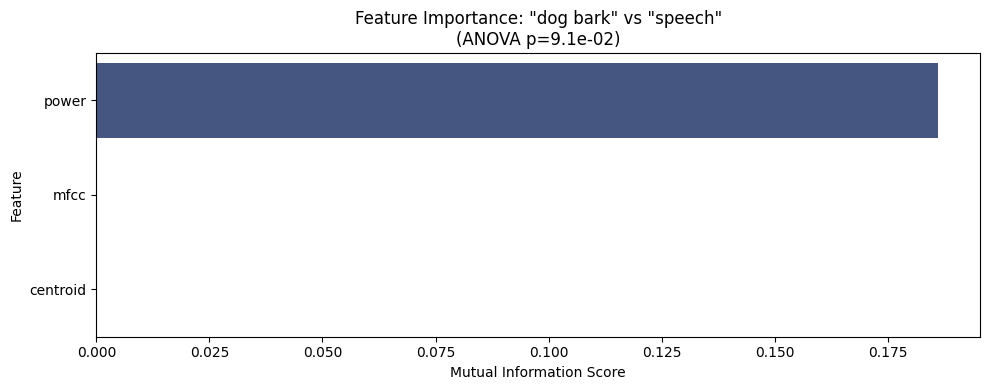


Mutual Information Scores:
    Feature  MI_Score
1     power    0.1861
0      mfcc    0.0000
2  centroid    0.0000

ANOVA p-value: 9.1e-02


In [90]:
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import f_oneway

def analyze_class_separation(
        class1, 
        class2, 
        feature_set=None, 
        temporal_aggregation=True,
        balance_classes=True,
        sample_rate=100):
    """
    Analyze feature importance for distinguishing two classes.
    Returns:
        mi_df (DataFrame): Mutual information scores
        p_value (float): Most significant ANOVA p-value
    """
    if feature_set is None:
        feature_set = ['mfcc', 'power', 'centroid']
    
    # Filter for common indices & classes
    common_idx = an_df.index.intersection(df_summary.index)
    if common_idx.empty:
        raise ValueError("No overlapping indices between datasets.")
    
    an_filt = an_df.loc[common_idx]
    df_filt = df_summary.loc[common_idx]
    mask = an_filt["labels"].isin([class1, class2])
    if not mask.any():
        raise ValueError(f"No samples with labels: {class1}, {class2}")
    
    y = an_filt.loc[mask, "labels"].dropna()
    X = df_filt.loc[y.index, feature_set].dropna(axis=1)
    y = y.loc[X.index]
    
    if X.empty or y.empty:
        raise ValueError("No data after filtering.")
    
    # Temporal aggregation
    if temporal_aggregation:
        window_sec = 0.02  # 20ms windows by default
        samples_per_win = int(window_sec * sample_rate)
        
        X = X.copy()
        X['labels'] = y
        X['time_window'] = np.arange(len(X)) // samples_per_win
        agg = X.groupby(['time_window', 'labels']).mean().reset_index()
        if agg.empty:
            raise ValueError("No data left after temporal aggregation.")
        
        y = agg['labels']
        X = agg.drop(columns=['time_window', 'labels'])
    
    if X.empty or y.empty:
        raise ValueError("No data after temporal aggregation.")
    
    # Balance classes if requested
    if balance_classes:
        from imblearn.under_sampling import RandomUnderSampler
        if y.nunique() < 2:
            raise ValueError("Need at least two classes to balance.")
        rus = RandomUnderSampler(random_state=42)
        X, y = rus.fit_resample(X, y)
        if len(y) == 0:
            raise ValueError("No data left after balancing.")
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Mutual information
    mi_scores = mutual_info_classif(X_scaled, y, random_state=42)
    mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores})\
            .sort_values('MI_Score', ascending=False)
    
    # ANOVA test
    groups = [X_scaled[np.array(y) == cls] for cls in [class1, class2]]
    if any(len(g) == 0 for g in groups):
        raise ValueError("Insufficient data for ANOVA test.")
    
    _, p_value = f_oneway(*groups)
    if isinstance(p_value, np.ndarray):
        p_value = p_value.min()
    
    # Plotting
    plt.figure(figsize=(10, 4))
    sns.barplot(data=mi_df, x='MI_Score', y='Feature', palette='viridis', legend=False)
    plt.title(f'Feature Importance: "{class1}" vs "{class2}"\n(ANOVA p={p_value:.1e})')
    plt.xlabel('Mutual Information Score')
    
    if mi_df['MI_Score'].max() > 0.5:
        plt.axvline(0.5, color='red', linestyle='--', alpha=0.3)
        plt.text(0.5, len(mi_df) - 0.5, 'Strong Separator', color='red')
    
    plt.tight_layout()
    plt.show()
    
    return mi_df, float(p_value)

# Usage example
try:
    mi_df, p_value = analyze_class_separation(
        "dog bark", 
        "speech",
        temporal_aggregation=True,
        balance_classes=True,
        sample_rate=32000
    )
    print("\nMutual Information Scores:")
    print(mi_df.round(4))
    print(f"\nANOVA p-value: {p_value:.1e}")
except Exception as e:
    print(f"\nError during analysis: {e}")


**Purpose:**
Identifies which features best distinguish between two sound classes using Mutual Information (MI). MI measures how much knowing a feature's value reduces uncertainty about the class.

**Key Insights:**

*1. MI Scores Interpretation:*

    Scores range 0-1 (higher = better class separation)

    - 0.5 → Excellent separator
    - 0.2-0.5 → Moderate utility
    - <0.2 → Weak predictor

*2. Visual Cues:*

- The barplot shows features ranked by discriminative power
- Red threshold line (at MI=0.5) highlights strongest features

**Conclusion:**
- Keep features above your MI threshold (>0.2)
- Re-evaluate features below threshold unless domain knowledge suggests importance

**FEATURE DISTRIBUTIONS FOR TOP FEATURES**

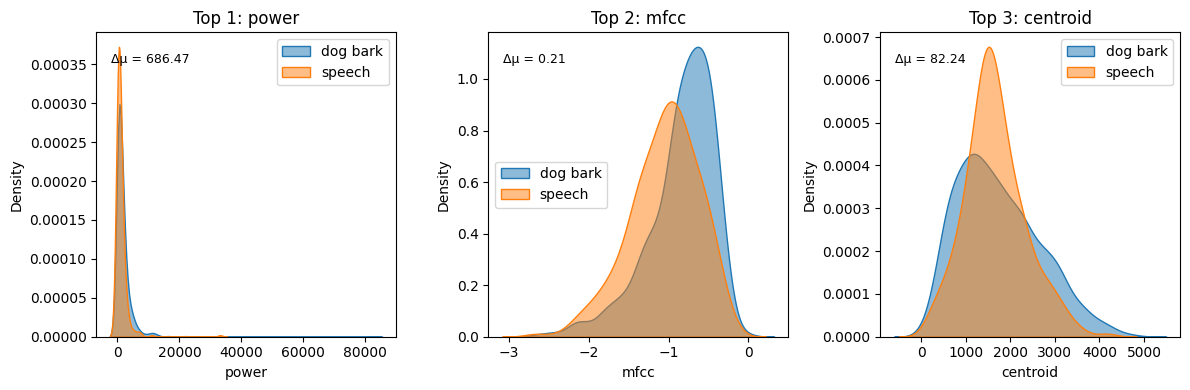

In [91]:
def plot_feature_distributions(mi_df, class1, class2, n_top=3):
    """Plot distributions of top N most important features"""
    top_features = mi_df.head(n_top)['Feature'].tolist()
    
    plt.figure(figsize=(4 * n_top, 4))
    
    # Prepare merged DataFrame with labels and features, aligned on common indices
    common_idx = an_df.index.intersection(df_summary.index)
    merged_df = df_summary.loc[common_idx, top_features].join(an_df.loc[common_idx, 'labels'])
    
    for i, feat in enumerate(top_features, 1):
        plt.subplot(1, n_top, i)
        for cls in [class1, class2]:
            data = merged_df[merged_df['labels'] == cls][feat].dropna()
            if not data.empty:
                sns.kdeplot(data, label=cls, fill=True, alpha=0.5)
            else:
                plt.text(0.5, 0.5, f'No data for {cls}', ha='center', va='center')
        
        # Effect size (mean difference)
        mean_diff = merged_df[merged_df['labels'] == class1][feat].mean() - \
                    merged_df[merged_df['labels'] == class2][feat].mean()
        plt.annotate(f'Δμ = {mean_diff:.2f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=9)
        
        plt.title(f'Top {i}: {feat}')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Usage example (assuming mi_df from analyze_class_separation)
plot_feature_distributions(mi_df, "dog bark", "speech", n_top=3)

**Purpose:**
Visualizes how feature distributions differ between classes to complement MI scores.

**Key Insights:**

*1. Distribution Shapes:*

- Well-separated peaks → Feature is discriminative
- Overlapping curves → Feature is less useful

*2. Effect Size (Δμ):*

- The annotated mean difference quantifies separation magnitude
- Rule of thumb: Δμ > 1 standard deviation → Strong effect

We prioritize features with:
- High MI scores AND
- Cleanly separated distributions:
    
    Investigate further when:
    - High MI but overlapping distributions (possible outliers)
    - Low MI but clean separation (check feature scaling)

#### (c) How well do the chosen audio features group according to the discretized class labels? 

*(Linked to 1a's label accuracy and 1b's feature importance)*

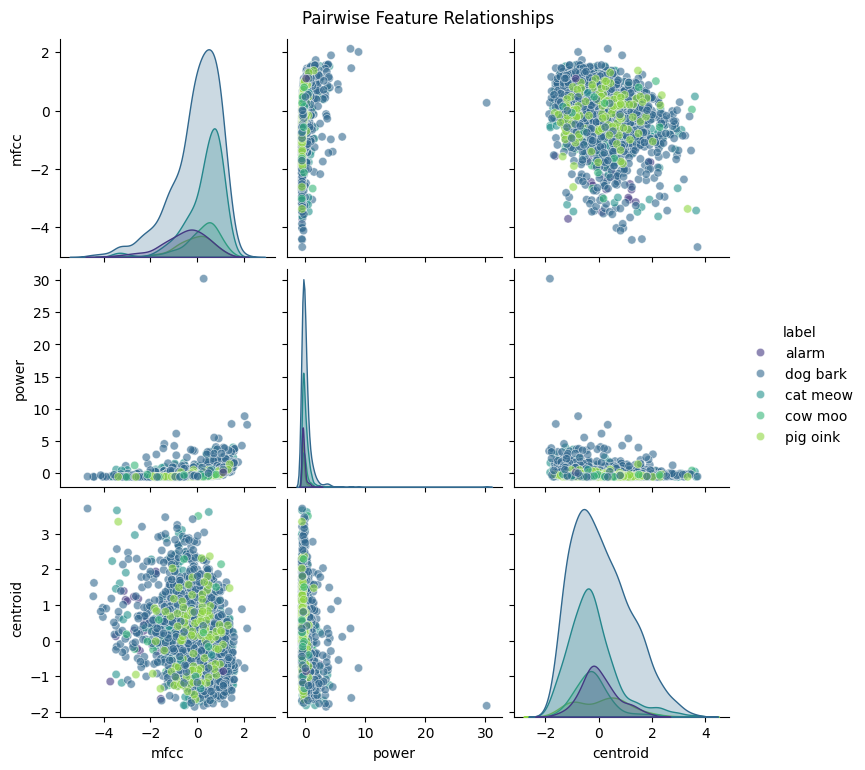

In [92]:
from sklearn.metrics import silhouette_score

# Select top 5 classes and top 3 features based on previous analysis
top_classes = ['cat meow', 'dog bark', 'cow moo', 'alarm', 'pig oink']
top_features = ['mfcc', 'power', 'centroid']

# Prepare data - using actual features this time
# (Assuming we have metadata DataFrame meta_df and annotations DataFrame an_df)
common_idx = an_df.index.intersection(meta_df.index)
an_filt = an_df.loc[common_idx]
meta_filt = meta_df.loc[common_idx]

# Filter for our top classes
class_mask = an_filt['labels'].isin(top_classes)
an_top = an_filt[class_mask]
meta_top = meta_filt[class_mask]

# Load features for these samples
X = []
for idx, row in meta_top.iterrows():
    file_name = f"{row['filename']}".replace('.mp3', '.npz')
    path = os.path.join(AUDIO_FEATURE_FOLDER, file_name)
    features = np.load(path)
    # Take mean of each feature across time frames
    sample_features = [np.mean(features[feat]) for feat in top_features]
    X.append(sample_features)
X = np.array(X)
y = an_top['labels'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Pairwise scatterplots of top features
sns.pairplot(
    pd.DataFrame(X_scaled, columns=top_features).assign(label=y),
    hue='label',
    palette='viridis',
    plot_kws={'alpha': 0.6}
)
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

#### Do samples of the same class form tight clusters?

*(Quantifies the visual intuition from the cell above)*

In [93]:
# Evaluate cluster quality
try:
    silhouette_pca = silhouette_score(X_pca, y)
    silhouette_tsne = silhouette_score(X_tsne, y)
    print(f"Silhouette Score (PCA): {silhouette_pca:.3f}")
    print(f"Silhouette Score (t-SNE): {silhouette_tsne:.3f}")
except ValueError as e:
    print(f"Could not compute silhouette score: {e}")

Silhouette Score (PCA): -0.192
Silhouette Score (t-SNE): -0.154
